In [1]:
import os
import shutil
from pathlib import Path
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from eigvec.circulant import compute_kappa

## Circulant Covariance and Allen Data

This notebook shows as the number of rows (e.g. trials and channels) increase, the covariance matrix becomes increasingly circulant. First, LFP data from the Allen Instituted is loaded. The next two cells take a long time to run. This notebook requires ~16gb free memory, less may run into errors.

In [2]:
# Paths
output_dir = '../data/ecephys_cache_dir'

manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

# First mouse
session = cache.get_session_data(
    sessions.index.values[0],
    isi_violations_maximum = np.inf,
    amplitude_cutoff_maximum = np.inf,
    presence_ratio_minimum = -np.inf
)

# Load LFP on first probe
probe_id = session.probes[session.probes.description == 'probeA'].index.values[0]
lfp = session.get_lfp(probe_id)

# Get trial names, ignore "spontaneous" because of too little data
trial_names = np.unique(session.stimulus_presentations.stimulus_name.values)
trial_names = [i for i in trial_names if i != 'spontaneous']

In [3]:
# Lists to store results for each trial
freqs = []
powers = []

kappas = []
ratios = []

trials = []

# For each trial type, compute kappa
for it, tname in enumerate(trial_names):

    # Epoch data around events
    presentation_table = session.stimulus_presentations[
        session.stimulus_presentations.stimulus_name == tname
    ]

    presentation_times = presentation_table.start_time.values
    presentation_ids = presentation_table.index.values
    
    trial_window = np.arange(-0.5, 0.5, 1/500)
    time_selection = np.concatenate([trial_window + t for t in presentation_times])
    
    inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))
    
    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    # Get LFP
    X = ds['aligned_lfp']
    del ds
    
    X = X.to_numpy()
    X = X.reshape(-1, 500)
    
    # Drop nan rows
    not_nan = ~np.isnan(X.sum(axis=1))
    if not_nan.sum() == 0:
        continue
    else:
        X = X[not_nan]
        
    # Max at 0.5 million rows to prevent OOM
    X = X[:500_000]
    
    # Compute covariance
    cov = np.cov(X.T)

    # Size of random samples
    inds = np.arange(len(X))
    sizes = np.logspace(1, np.log10(len(X)-1), 10).astype(int)

    # Number of random samples, per size
    n_rand_samples = 10
    
    # Compute kappa across sizes
    k = np.zeros(len(sizes)) 
    
    for i_k, i in tqdm(enumerate(sizes), total=len(sizes)):

        # Randomly sample i rows a few times, and take mean kappa of all
        for _ in range(n_rand_samples):
            
            inds_sub = np.sort(np.random.choice(inds, i, replace=False))
        
            cov = np.cov(X[inds_sub].T)
    
            k[i_k] += compute_kappa(cov)

        k[i_k] = k[i_k] / n_rand_samples

     # PSD
    _freqs = np.fft.fftfreq(len(X[0]), 1/500)[1:250]
    _powers = np.zeros((len(X), len(_freqs)))
                      
    for j, x in enumerate(X):
        xnorm = (x - x.mean()) / x.std()
        _powers[j] = (np.abs(np.fft.fft(xnorm))**2)[1:250]

    pmean = _powers.mean(axis=0)
    
    kappas.append(k)
    ratios.append(sizes/X.shape[1])
    freqs.append(_freqs)
    powers.append(pmean)
    trials.append(tname)
    
    # Prevent OOM when next ds is loaded
    del X, _freqs, _powers, cov

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Plot

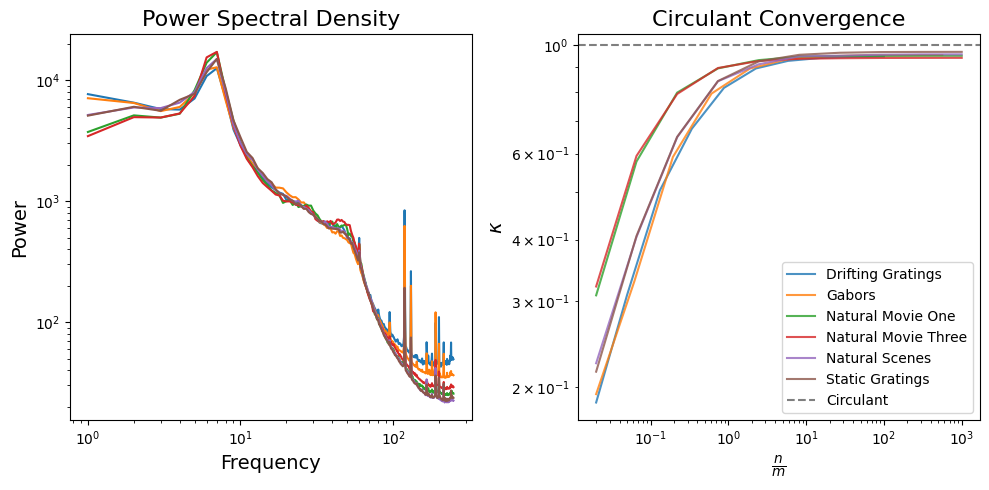

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# trail[1] has all nans, skip
labels = [t for i, t in enumerate(trial_names) if i != 1]

for r, k, l, f, p in zip(ratios, kappas, labels, freqs, powers):
    # PSD
    axes[0].loglog(f, p)

    # Kappa
    label = " ".join([i.capitalize() for i in l.split("_")])
    axes[1].loglog(r, k, alpha=.8, label=label)
   

axes[1].axhline(1., color='k', alpha=.5, ls='--', label='Circulant')
axes[1].legend()

axes[0].set_title('Power Spectral Density', size=16)
axes[1].set_title('Circulant Convergence', size=16)
axes[0].set_ylabel('Power', size=14)
axes[1].set_ylabel(r'$\kappa$', size=14)
axes[0].set_xlabel("Frequency", size=14)
axes[1].set_xlabel(r"$\frac{n}{m}$", size=14)

plt.tight_layout();
plt.savefig("allen.png", dpi=300)